
## extra step 생성

여태까지 Lightning moudle 을 상속받아 다음을 재구성하여 모델을 생성해보았다

- \_\_init\_\_() : 신경망을 구성하는데 사용 (layer 정의)
- forward() : 실제로 신경망에 x 가 들어갔을 때 나오는 y 를 정의 -> 실제로 call 은 forward를 부르는게 아니라 오브젝트를 call 해야함 (나중에 hook등이 동작하게 하기 위해서)
- traning_step : 데이터를 넣었을 때, loss 를 계산하는 방법을 정의 (따라서 traning step 내부에는 당연히 forward 가 포함된 model() call이 있어야 한다) 하고 loss 를 리턴한다.
- validation_step : validation 방법을 정의한다. 별도의 return 은 없어도 된다. (없어도 모델은 돌아감)
- test_step : test 방법을 정의한다. 별도의 return 은 없어도 된다.
  

이를 활용한 기본 모델의 뼈대는 아래와 같다

In [71]:
## 1~5 장까지 실습한 내용
import torch
from torch import nn
from torch.nn import functional as F
import torch.optim as optim

import pytorch_lightning as pl
from pytorch_lightning.accelerators import accelerator
from torchmetrics import functional as FM
from torchinfo import summary

from torchvision.datasets import MNIST
import torchvision.transforms as transforms
import torch.utils.data as data
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


class Model(pl.LightningModule):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(28*28, 32)
        self.dense2 = nn.Linear(28*28, 32)
        self.dense2_2= nn.Linear(32, 16)
        self.dense3 = nn.Linear(32+16, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)

        x1 = self.dense1(x)
        x1 = self.relu(x1)

        x2_1 = self.dense2(x)
        x2_1 = self.relu(x2_1)
        x2_2 = self.dense2_2(x2_1)
        x2_2 = self.relu(x2_2)

        x = torch.cat([x1, x2_2], dim=1)
        x = self.dense3(x)

        return(x)
        


def dataLoader(batch_size=128):
    train_dataset = MNIST('', transform=transforms.ToTensor(), train=True, download=True) ## 한 번 인터넷으로 가져온걸 매번 가져올 필요가 없기 때문에 가져올때 download True 로 하면 다음 부터는 다운로드 된 데이터를 사용한다.
    test_dataset = MNIST('', transform=transforms.ToTensor(), train=False, download=True)
    trainDataLoader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valDataLoader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return (trainDataLoader,valDataLoader)

trainDataLoader,valDataLoader = dataLoader()

In [9]:
loss_function = nn.CrossEntropyLoss()
class MyModel(pl.LightningModule):
    def __init__(self):
        super(MyModel, self).__init__()
        self.layers =  Model()

    def forward(self, x):
        out = self.layers(x)
        return out

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = loss_function(y_pred, y)
        acc = FM.accuracy(y_pred, y, task="multiclass",num_classes=10)
        mse = FM.mean_squared_error(torch.argmax(y_pred, dim=1), y)
        metrics={'loss': loss, 'acc':acc, 'mse': mse}
        self.log_dict(metrics,prog_bar=True)#on_step=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = loss_function(y_hat, y)
        acc = FM.accuracy(y_hat, y, task="multiclass",num_classes=10)
        mse = FM.mean_squared_error(torch.argmax(y_hat, dim=1), y)
        metrics={'val_loss': loss, 'val_acc':acc, 'val_mse': mse}
        self.log_dict(metrics) #on_step=False, on_epoch=True

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = loss_function(y_hat, y)
        acc = FM.accuracy(y_hat, y, task="multiclass",num_classes=10)
        metrics={'test_loss': loss, 'test_acc':acc}
        self.log_dict(metrics)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

model = MyModel()
#summary(model, input_size=(8, 1, 28, 28))

epochs=3
trainer = pl.Trainer(max_epochs=epochs, accelerator='auto')
trainer.fit(model, trainDataLoader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\msong\miniconda3\Lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:71: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type  | Params
---------------------------------
0 | layers | Model | 51.3 K
---------------------------------
51.3 K    Trainable params
0         Non-trainable params
51.3 K    Total params
0.205     Total estimated model params size (MB)
C:\Users\msong\miniconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in t

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


validation step 과 test step 이 모두 정의가 되었기 때문에 아래와 같이 valdiate 나 test 메쏘드를 사용가능하다

In [10]:
trainer.validate(model, valDataLoader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\msong\miniconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.validating metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.9506000280380249
        val_loss            0.16787856817245483
         val_mse            0.8942999839782715
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.16787856817245483,
  'val_acc': 0.9506000280380249,
  'val_mse': 0.8942999839782715}]

In [11]:
trainer.test(model, valDataLoader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\msong\miniconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.testing metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9506000280380249
        test_loss           0.16787856817245483
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.16787856817245483, 'test_acc': 0.9506000280380249}]

또한 별도의 forward() 를 이용하여 학습된 모델을 실행하는 별도의 process 를 생성할 수 도 있다.

In [49]:
class altModel(MyModel):

    def predict_step(self, x, batch_idx):
        y_pred = self(x) ## < forward 에 x를 넣어서 나온 결과 ==> logit 상태임
        y_pb = nn.Softmax(y_pred) ## logit 을 Softmax 취해서 확률로 바꿈
        return y_pb
        

In [50]:
model = altModel()

In [51]:

epochs=3
trainer = pl.Trainer(max_epochs=epochs, accelerator='auto')
trainer.fit(model, trainDataLoader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type  | Params
---------------------------------
0 | layers | Model | 51.3 K
---------------------------------
51.3 K    Trainable params
0         Non-trainable params
51.3 K    Total params
0.205     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


In [52]:
batch = next(iter(valDataLoader)) ##  데이터 로더에서 1개 배치 가져오기 

In [53]:
print(batch[0].shape) # x 
print(batch[1].shape) # y

torch.Size([128, 1, 28, 28])
torch.Size([128])


배치사이즈가 128개씩 이므로 이중에서 가장 첫번째 x 만 보면

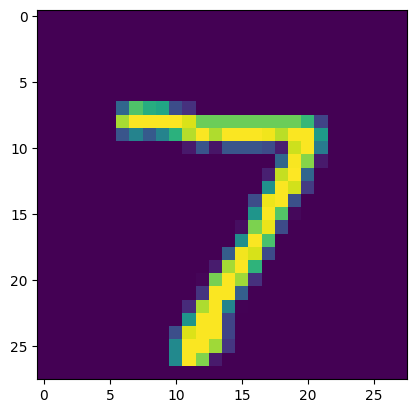

In [54]:
plt.imshow(batch[0][0].squeeze())

위와 같은 글씨임을 알 수 있다. 이걸 실제 모델에 넣어서 forward 시켜보면 

In [55]:
y_logit = model(batch[0][0])

In [56]:
y_logit.shape
y_logit[0]

tensor([ -1.9990,  -8.6402,   1.3585,   2.4129,  -6.7126,  -1.5154, -11.8695,
          8.9260,  -3.0257,  -0.7638], grad_fn=<SelectBackward0>)

위와 같은 logit 값을 볼 수 있는데, 여기에 softmax 를 취해서 변화하는게 바로 각 class 에 해당하는 probability 이므로 이걸 정의한게 위의 predict 매쏘드이다.

따라서 model 에 batch 를 넣으면 logit 에 해당하는 값을 얻을 수 있다. 

In [62]:
y_predcit_with_logit = model(batch[0])

하지만 보통 대부분의 경우 우리가 관심이 있는 값들은 logit 이 아니라 이걸 확률로 변환한 prob 값인데, 우리가 predict_step 에 대해 정의를 했기 때문에, 이제 Trainer  에서도 predict를 사용할 수 있다. (model 에서 predict_step 이 정의가 되었기 때문에 활용가능)

In [64]:
y_predict_with_prob = trainer.predict(model, batch[0])

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

단 주의할점이 있는데, predict step 의 결과는 Softmax를 취한 logit 자체이지, 그 값이 아니다. 이해하기 힘들겠지만, 아래 결과를 보면 logit으로 나온 값을 보면 모델을 통과한 뒤에 각 class 에 해당하는 어떤 계산 값들이다. 반면 우리가 predict 한 값은 여기에 Softmax layer를 취해야 한다는걸 알려주지, 그 값을 알려주지는 않는다. (물론 나중에 여기에 argmax 등을 할 때에는 softmax를 취한 값의 argmax가 취해진다. -> 지금은 이해가 안되도 넘어가도록 하자)

In [69]:
print(y_predcit_with_logit[0])
print(y_predict_with_prob[0])


tensor([ -1.9990,  -8.6403,   1.3585,   2.4129,  -6.7126,  -1.5154, -11.8695,
          8.9260,  -3.0257,  -0.7638], grad_fn=<SelectBackward0>)
Softmax(
  dim=tensor([[ -1.9990,  -8.6403,   1.3585,   2.4129,  -6.7126,  -1.5154, -11.8695,
             8.9260,  -3.0257,  -0.7638]], device='cuda:0')
)


그럼 실제로 추론하는 과정을 대략적으로 이해해보면

In [110]:
batch = next(iter(valDataLoader))  ## 데이터로더로부터 다음의 batch 를 가져온다.

model.eval() ## evaluation mode로 바꾼다. (drop out, batch normalization 등)

y_pred = model(batch[0]) # batch 의 x 가 들어간다. input(128, 1, 28, 28) -> output (128, 10)

print(y_pred.size()) ## tensor with 128 x 10
print(y_pred[0, :])  ## 그 중 첫번째의 logit values, numpy 와 비슷하지만 뒤에 grad 정보가 있기 때문에 바로 그리거나 할 수 는 없음 이를 detach

print("----")
# 주의 np.argmax( y_predict[0, :] ) 불가
print(y_pred[0, :].detach())  ## grad_fn 부분이 사라진다.
print("----")
softmax =  nn.Softmax(dim=0) 
print( softmax( y_pred[0, :].detach()  )) 
print("----")
print(np.argmax(softmax( y_pred[0, :].detach() ))) ## 이중 최대값의 argmax 


torch.Size([128, 10])
tensor([ -1.9990,  -8.6403,   1.3585,   2.4129,  -6.7126,  -1.5154, -11.8695,
          8.9260,  -3.0257,  -0.7638], grad_fn=<SliceBackward0>)
----
tensor([ -1.9990,  -8.6403,   1.3585,   2.4129,  -6.7126,  -1.5154, -11.8695,
          8.9260,  -3.0257,  -0.7638])
----
tensor([1.7965e-05, 2.3452e-08, 5.1593e-04, 1.4808e-03, 1.6119e-07, 2.9138e-05,
        9.2838e-10, 9.9789e-01, 6.4346e-06, 6.1784e-05])
----
tensor(7)


위와 같이 이루어진다고 보면 된다. 단 여기서 grad 가 포함되어 있는 Tensor는 일반적인 numpy 연산이 안되기 때문에 grad 부분을 때주는 detach를 해주거나 아니면 아래처럼 no_grad 옵션을 줘야한다.  (아래 예제코드의 경우 : 사실 제대로 하면 softmax를 취한 다음에 argmax를 해야하지만 일반적으로 logit 이 최고인 값이 softmax도 최고이기 때문에 확률로 변환된 값이 필요한게 아니라면(그냥 최대값만 보고 싶으면) 여기서 바로 argmax 해도 된다)


In [109]:
batch = next(iter(valDataLoader)) # ((128,1,28,28),(128,10))
## Sets the module in evaluation mode.(Dropout,BN,..)
model.eval()

## disabled gradient calculation.(reduce memory)
with torch.no_grad():             ### w/o grad_fn object ###
    y_predict = model(batch[0])   # model <- image only

## y_predict 는 이제 grad 가 없는 상태임

print(y_predict,'\n')                 # (128,10) tensor, w/o grad_fn
print(y_predict[0,:],'\n')            # (10,)    tensor, w/o grad_fn
print(np.argmax(y_predict[0,:].numpy()),'np') # numpy index
print(np.argmax(y_predict[0,:]),'tensor') # tensor index

tensor([[ -1.9990,  -8.6403,   1.3585,  ...,   8.9260,  -3.0257,  -0.7638],
        [  0.1254,  -1.5450,   6.8217,  ..., -12.3396,  -0.9260,  -8.7171],
        [ -5.1869,   5.5554,  -0.1129,  ...,  -0.3302,  -1.3250,  -4.0489],
        ...,
        [ -8.0665,  -3.4997,  -0.8681,  ...,  -1.4528,  -1.7214,   2.7112],
        [  4.5235,  -6.4920,   0.7036,  ...,  -3.0617,  -2.1172,   0.8550],
        [ -2.1980,  -4.6622,  -3.5125,  ...,  -9.0685,   0.0601,  -3.7213]]) 

tensor([ -1.9990,  -8.6403,   1.3585,   2.4129,  -6.7126,  -1.5154, -11.8695,
          8.9260,  -3.0257,  -0.7638]) 

7 np
tensor(7) tensor


In [114]:
print(np.argmax(model(batch[0]).detach(),axis=1).numpy(),'ndarray')  # 예측한 숫자

[7 2 1 0 4 1 4 9 6 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1 3 4 7 2 7
 1 2 1 1 7 4 2 3 5 1 2 4 4 6 3 5 5 6 0 4 1 9 5 7 8 9 3 7 4 6 4 3 0 7 0 2 9
 1 7 3 2 9 7 7 6 2 7 8 4 7 3 6 1 3 6 9 3 1 4 1 7 6 9 6 0 5 4 9 9 2 1 9 4 8
 7 3 9 7 4 4 4 9 2 5 4 7 6 7 9 0 5] ndarray


In [115]:
print(batch[1],'Tensor') # 정답 Label

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4, 6, 4, 3, 0, 7, 0,
        2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 9, 3, 1, 4,
        1, 7, 6, 9, 6, 0, 5, 4, 9, 9, 2, 1, 9, 4, 8, 7, 3, 9, 7, 4, 4, 4, 9, 2,
        5, 4, 7, 6, 7, 9, 0, 5]) Tensor
